# Data Preparation

### Problemi
- Le immagini sono molto pesanti (2000x2000)
- Se ridimensionassi avrei perdita di informazione e dettaglio
- Se estraessi le features, come ricostruirei il frame nel futuro?

### Passaggi:
- Eliminazione dati nulli/outliers
- Feature engineering/riduzione dimensionalitá
    - Resize semplice (lossy)
    - PCA 
        (PROBLEMA ricostruzione)
    - Autoencoder per rappresentazione compressa
        - https://paperswithcode.com/paper/an-end-to-end-compression-framework-based-on
    - Variabili selezionate da Random Forest 
        (PROBLEMA ricostruzione)
    - Correlazione con l'output (matrice successiva)
- Trasformazione dei valori (normalizzazione/standardizzazione)

### Steps in Data Science
- Preparare i dati
    - Feature Engineering (estrazione)
    - Trasformazione (categorie, normalizzazione)
    - Rimozione outliers
    - Gestione valori mancanti
    - Riduzione features
    


### Errori comuni
- Variabili anacronistiche
- Biased train-test-split
- Campionamento troppo piccolo
- Ignoro outliers/mancanti
- Distribuzioni non normali ignorate

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

%cd drive/My\ Drive/SWE

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/SWE'
/content/drive/My Drive/SWE


In [4]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

### Data Import

In [5]:
timesteps = np.load('datasets/timesteps.npy')
print(timesteps.shape)

(1000, 1, 300, 300)


### Analisi serie temporale con ARIMA
Si analizza il problema con l'applicazione dell'algoritmo ARIMA (Auto Regressive Integrated Moving Average). Questa tecnica statistica si applica su una serie temporale univariata, a patto che sia stazionaria.

In [ ]:
sums = [np.sum(t) for t in timesteps]
sums_df = pd.DataFrame(
    data = sums,
    columns = ["value"]
)

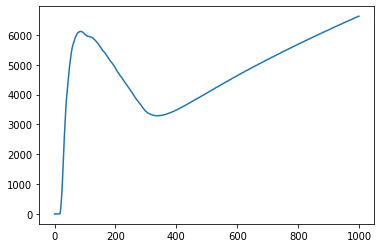

In [ ]:
# Semplifico ogni matrice temporale con un solo numero (somma di tutte le celle)
plt.plot(sums_df)
pass

#### Test di Dicky-Fuller
Bisogna verificare se la serie temporale é stazionaria

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_check(data, verbose = True):
    result = adfuller(data)
    if verbose: print("Augmented Dicky-Fuller Test")
    labels = ["ADF Test Statistic", "p-value", "# of lags", "# observations used"]
    
    for value,label in zip(result, labels):
        if verbose: print("{}: {}".format(label, value))
        
    if result[1] <= 0.05:
        if verbose: print("Strong evidence against null hypothesis")
        if verbose: print("No unit root, data is stationary")
        return True
    # > 0.05
    else:
        if verbose: print("Weak evidence against null hypothesis")
        if verbose: print("There is root unit, data non stationary")
        return False

In [ ]:
adf_check(sums_df["value"])

Augmented Dicky-Fuller Test
ADF Test Statistic: -1.252588328538688
p-value: 0.650574697544392
# of lags: 22
# observations used: 977
Weak evidence against null hypothesis
There is root unit, data non stationary


False

#### Differenziazione K
Un metodo per rendere la serie stazionaria (mean e std fissi nel tempo) é differenziare per K iterazioni: si sottraggono ad ogni valore della serie i suoi K precedenti.

Stationarity reached with k = 1


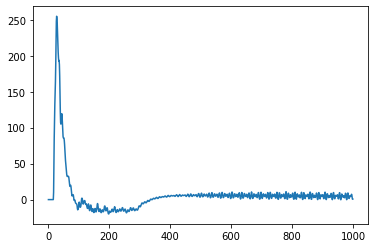

In [ ]:
# curr - previous
diff = sums_df
k = 1

# Early stopping se raggiungo giá una serie stazionaria
for i in range(k):
  diff["value"] = sums_df["value"] - sums_df["value"].shift(1)
  result = adf_check(diff["value"].dropna(), False)
  if result is True:
    print("Stationarity reached with k = {}".format(i+1))
    break

diff["value"].plot()

#### Autocorrelation
L'autocorrelazione puó essere d'aiuto per capire se applicare un modello piú basato sull'Auto Regressione o sul Moving Average.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

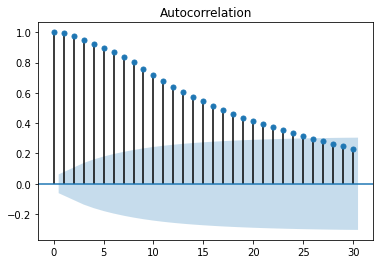

In [ ]:
# Gradual decline or sharp drop off?
fig_first = plot_acf(diff['value'].dropna())

#### ARIMA

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
train_size = int(sums_df["value"].dropna().shape[0] * 0.9)
train = sums_df["value"].dropna()[0:train_size]
test = np.asarray(sums_df["value"].dropna()[train_size:])

# Train
avg_err = []

# AR = 5 (lag size autoregressione)
# Differenzia di 1
# MA = 0 (moving average nullo)
for w in range(2, 10):
  error = []

  history = [v for v in train]
  predicted = [v for v in train]

  for t in range(len(test)):
    model = ARIMA(history, order=(w, 1, 0))
    model = model.fit()

    y_hat = model.forecast()[0]
    y = test[t]

    history.append(y)
    predicted.append(y_hat)

    # (Differenza / true) = % errore
    error.append(abs((y_hat - y)/y))
    #print("y_hat: {} - expected: {} - error: {}".format(y_hat, y, abs((y_hat - y)/y)))

    #if t % 10 == 0:
    #  print("Errore: {}%".format(round((np.mean(error)) * 100, 2)))

  print("Window: {} - Error: {}%".format(w, round((np.mean(error)) * 100, 2)))
  avg_err.append(round((np.mean(error)) * 100, 2))

Window: 2 - Error: 98.8%
Window: 3 - Error: 66.41%
Window: 4 - Error: 70.1%
Window: 5 - Error: 64.44%
Window: 6 - Error: 61.57%
Window: 7 - Error: 68.01%
Window: 8 - Error: 66.44%
Window: 9 - Error: 66.83%


In [ ]:
# Test con w = 5 (error = ~64%)
history = [v for v in train]
predicted = [v for v in train]
w = 5
for t in range(len(test)):
  model = ARIMA(history, order=(w, 1, 0))
  model = model.fit()

  y_hat = model.forecast()[0]
  y = test[t]

  history.append(y)
  predicted.append(y_hat)

  # (Differenza / true) = % errore
  error.append(abs((y_hat - y)/y))
  # print("y_hat: {} - expected: {} - error: {}".format(y_hat, y, abs((y_hat - y)/y)))

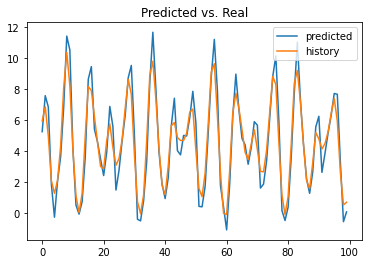

In [ ]:
plt.title("Predicted vs. Real")
plt.plot(predicted[train_size:], label="predicted")
plt.plot(history[train_size:], label="history")
plt.legend()

#### Conclusioni
- ARIMA é un modello limitato: é necessario prevedere piú feature trattandosi di un'immagine
- Il livello di precisione raggiunge al piú ~39%, non indicando una soluzione percorribile

### Synthetic Data Augmentation

In [48]:
from copy import deepcopy

def augment_array(a, alfa = 0.5):
  new = []
  old_t =  a[0]
  for t in tqdm.tqdm(a[1:]):

    # Add intermediate frame: t[i] * 1-alfa + alfa * t[i+1]
    middle = (1-alfa) * old_t + alfa * t

    new.append(old_t)
    new.append(middle)

    old_t = deepcopy(t)
  return np.asarray(new)


MULTIPLIER = 3
augmented = deepcopy(timesteps)

for k in range(MULTIPLIER):
  augmented = augment_array(augmented, 0.4)

100%|██████████| 3993/3993 [00:11<00:00, 362.78it/s]


### 3.Riduzione Dimensionalitá

In [ ]:
# Preparazione in N-w_size finestre temporali
# Ogni finestra: k-1 frames (features) + kesimo frame (target)
w_size = 10
w_timesteps = np.asarray([timesteps[i:+w_size] for i in range(timesteps.shape[0] - w_size)])
w_timesteps.shape

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(990,)

In [ ]:
X = np.asarray([t.flatten() for t in timesteps[:, 0]])
print("Data of shape: {}".format(X.shape))

Data of shape: (530, 114576)


In [ ]:
from sklearn.decomposition import PCA

compression = 100
components = min(X.shape)

# create the PCA instance
pca = PCA(components)
# fit on data
pca.fit(X)

# print(pca.components_)
# print(pca.explained_variance_)

# transform data
B = pca.transform(X)

print(B.shape)

(530,)


#### Compressione con autoencoder

In [ ]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        
        self.encoder_in = nn.Linear(input_shape, 2048)
        self.encoder_h1 = nn.Linear(2048, 2048)
        
        self.decoder_in = nn.Linear(2048, 2048)
        self.decoder_out = nn.Linear(2048, input_shape)

    def forward(self, x):
        
        x = torch.relu(self.encoder_in(x))
        x = torch.relu(self.encoder_h1(x))
        
        x = torch.relu(self.decoder_in(x))
        x = torch.relu(self.decoder_out(x))
        return x
    
    def get_compressed(self, x):
        x = torch.relu(self.encoder_in(x))
        x = torch.relu(self.encoder_h1(x))
        return x

In [ ]:
cuda = torch.device('cuda') 

flattened_img = timesteps[0, 0].flatten().shape[0]
autoencoder = AE(input_shape=flattened_img).to(cuda)

In [ ]:
epochs = 10

optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_size = int(timesteps.shape[0] * 0.7)
train_set = timesteps[:train_size]

for epoch in range(epochs):
    loss = 0
    
    print("epoch {}".format(epoch))
    for index in tqdm.tqdm(range(train_set.shape[0])):        
        
        optimizer.zero_grad()
        
        picture = train_set[index, 0]
        picture = torch.Tensor(picture.flatten()).to(cuda)
        
        Y_hat = autoencoder(picture)
        
        train_loss = criterion(Y_hat, picture)
        
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
    
    print("Avg epoch loss: {}".format(loss/timesteps.shape[0]))





  0%|          | 0/700 [00:00<?, ?it/s]



  0%|          | 1/700 [00:00<02:01,  5.75it/s]

epoch 0






  0%|          | 2/700 [00:00<01:59,  5.85it/s]



  0%|          | 3/700 [00:00<01:58,  5.88it/s]



  1%|          | 4/700 [00:00<01:57,  5.90it/s]



  1%|          | 5/700 [00:00<01:57,  5.94it/s]



  1%|          | 6/700 [00:01<01:56,  5.95it/s]



  1%|          | 7/700 [00:01<01:56,  5.97it/s]



  1%|          | 8/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 9/700 [00:01<01:55,  5.97it/s]



  1%|▏         | 10/700 [00:01<01:55,  5.97it/s]



  2%|▏         | 11/700 [00:01<01:55,  5.99it/s]



  2%|▏         | 12/700 [00:02<01:54,  6.00it/s]



  2%|▏         | 13/700 [00:02<01:54,  6.01it/s]



  2%|▏         | 14/700 [00:02<01:53,  6.02it/s]



  2%|▏         | 15/700 [00:02<01:53,  6.01it/s]



  2%|▏         | 16/700 [00:02<01:53,  6.02it/s]



  2%|▏         | 17/700 [00:02<01:53,  6.02it/s]



  3%|▎         | 18/700 [00:03<01:53,  6.02it/s]



  3%|▎         | 19/700 [00:03<01:52,  6.03it/s]



  3%|▎         | 20/700 [00:03<01:52,  6.03it/s]



  3%|▎         |

Avg epoch loss: 0.0005146440768033926
epoch 1






  0%|          | 2/700 [00:00<01:55,  6.06it/s]



  0%|          | 3/700 [00:00<01:55,  6.04it/s]



  1%|          | 4/700 [00:00<01:55,  6.03it/s]



  1%|          | 5/700 [00:00<01:55,  6.03it/s]



  1%|          | 6/700 [00:00<01:55,  6.03it/s]



  1%|          | 7/700 [00:01<01:54,  6.03it/s]



  1%|          | 8/700 [00:01<01:54,  6.03it/s]



  1%|▏         | 9/700 [00:01<01:54,  6.04it/s]



  1%|▏         | 10/700 [00:01<01:54,  6.04it/s]



  2%|▏         | 11/700 [00:01<01:54,  6.04it/s]



  2%|▏         | 12/700 [00:01<01:53,  6.04it/s]



  2%|▏         | 13/700 [00:02<01:53,  6.04it/s]



  2%|▏         | 14/700 [00:02<01:53,  6.04it/s]



  2%|▏         | 15/700 [00:02<01:53,  6.04it/s]



  2%|▏         | 16/700 [00:02<01:53,  6.04it/s]



  2%|▏         | 17/700 [00:02<01:53,  5.99it/s]



  3%|▎         | 18/700 [00:02<01:53,  6.00it/s]



  3%|▎         | 19/700 [00:03<01:53,  6.00it/s]



  3%|▎         | 20/700 [00:03<01:53,  6.00it/s]



  3%|▎         |

Avg epoch loss: 0.00044278605389534676
epoch 2






  0%|          | 2/700 [00:00<01:55,  6.06it/s]



  0%|          | 3/700 [00:00<01:55,  6.05it/s]



  1%|          | 4/700 [00:00<01:55,  6.04it/s]



  1%|          | 5/700 [00:00<01:55,  6.03it/s]



  1%|          | 6/700 [00:00<01:55,  6.00it/s]



  1%|          | 7/700 [00:01<01:55,  6.00it/s]



  1%|          | 8/700 [00:01<01:55,  6.00it/s]



  1%|▏         | 9/700 [00:01<01:55,  6.00it/s]



  1%|▏         | 10/700 [00:01<01:54,  6.01it/s]



  2%|▏         | 11/700 [00:01<01:55,  5.94it/s]



  2%|▏         | 12/700 [00:02<01:55,  5.96it/s]



  2%|▏         | 13/700 [00:02<01:54,  5.97it/s]



  2%|▏         | 14/700 [00:02<01:54,  5.98it/s]



  2%|▏         | 15/700 [00:02<01:54,  5.98it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.97it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.98it/s]



  3%|▎         | 18/700 [00:03<01:53,  5.98it/s]



  3%|▎         | 19/700 [00:03<01:53,  6.00it/s]



  3%|▎         | 20/700 [00:03<01:53,  6.00it/s]



  3%|▎         |

Avg epoch loss: 0.0004293674787856016
epoch 3






  0%|          | 2/700 [00:00<01:55,  6.07it/s]



  0%|          | 3/700 [00:00<01:55,  6.03it/s]



  1%|          | 4/700 [00:00<01:55,  6.02it/s]



  1%|          | 5/700 [00:00<01:55,  6.02it/s]



  1%|          | 6/700 [00:00<01:55,  6.01it/s]



  1%|          | 7/700 [00:01<01:55,  6.01it/s]



  1%|          | 8/700 [00:01<01:55,  6.01it/s]



  1%|▏         | 9/700 [00:01<01:54,  6.01it/s]



  1%|▏         | 10/700 [00:01<01:54,  6.01it/s]



  2%|▏         | 11/700 [00:01<01:54,  6.01it/s]



  2%|▏         | 12/700 [00:01<01:54,  6.01it/s]



  2%|▏         | 13/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 14/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 15/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.97it/s]



  3%|▎         | 18/700 [00:03<01:54,  5.98it/s]



  3%|▎         | 19/700 [00:03<01:55,  5.90it/s]



  3%|▎         | 20/700 [00:03<01:54,  5.92it/s]



  3%|▎         |

Avg epoch loss: 0.0020792904814808505
epoch 4






  0%|          | 2/700 [00:00<01:55,  6.05it/s]



  0%|          | 3/700 [00:00<01:55,  6.05it/s]



  1%|          | 4/700 [00:00<01:55,  6.05it/s]



  1%|          | 5/700 [00:00<01:55,  6.04it/s]



  1%|          | 6/700 [00:00<01:55,  6.03it/s]



  1%|          | 7/700 [00:01<01:55,  6.02it/s]



  1%|          | 8/700 [00:01<01:55,  6.01it/s]



  1%|▏         | 9/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 10/700 [00:01<01:55,  5.99it/s]



  2%|▏         | 11/700 [00:01<01:54,  6.00it/s]



  2%|▏         | 12/700 [00:01<01:54,  6.01it/s]



  2%|▏         | 13/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 14/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 15/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.99it/s]



  3%|▎         | 18/700 [00:02<01:54,  5.98it/s]



  3%|▎         | 19/700 [00:03<01:53,  5.97it/s]



  3%|▎         | 20/700 [00:03<01:53,  5.97it/s]



  3%|▎         |

Avg epoch loss: 0.0020801244764228457
epoch 5






  0%|          | 2/700 [00:00<01:55,  6.04it/s]



  0%|          | 3/700 [00:00<01:55,  6.04it/s]



  1%|          | 4/700 [00:00<01:55,  6.03it/s]



  1%|          | 5/700 [00:00<01:55,  6.02it/s]



  1%|          | 6/700 [00:01<01:55,  5.98it/s]



  1%|          | 7/700 [00:01<01:55,  5.98it/s]



  1%|          | 8/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 9/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 10/700 [00:01<01:55,  5.99it/s]



  2%|▏         | 11/700 [00:01<01:55,  5.97it/s]



  2%|▏         | 12/700 [00:02<01:55,  5.97it/s]



  2%|▏         | 13/700 [00:02<01:55,  5.96it/s]



  2%|▏         | 14/700 [00:02<01:54,  5.97it/s]



  2%|▏         | 15/700 [00:02<01:54,  5.97it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.96it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.97it/s]



  3%|▎         | 18/700 [00:03<01:54,  5.98it/s]



  3%|▎         | 19/700 [00:03<01:54,  5.95it/s]



  3%|▎         | 20/700 [00:03<01:54,  5.96it/s]



  3%|▎         |

Avg epoch loss: 0.0020801863900460375
epoch 6






  0%|          | 2/700 [00:00<01:55,  6.05it/s]



  0%|          | 3/700 [00:00<01:55,  6.02it/s]



  1%|          | 4/700 [00:00<01:55,  6.01it/s]



  1%|          | 5/700 [00:00<01:55,  6.00it/s]



  1%|          | 6/700 [00:01<01:56,  5.98it/s]



  1%|          | 7/700 [00:01<01:56,  5.96it/s]



  1%|          | 8/700 [00:01<01:55,  5.98it/s]



  1%|▏         | 9/700 [00:01<01:55,  5.98it/s]



  1%|▏         | 10/700 [00:01<01:55,  5.99it/s]



  2%|▏         | 11/700 [00:01<01:55,  5.98it/s]



  2%|▏         | 12/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 13/700 [00:02<01:55,  5.96it/s]



  2%|▏         | 14/700 [00:02<01:55,  5.94it/s]



  2%|▏         | 15/700 [00:02<01:54,  5.96it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.97it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.97it/s]



  3%|▎         | 18/700 [00:03<01:54,  5.97it/s]



  3%|▎         | 19/700 [00:03<01:53,  5.97it/s]



  3%|▎         | 20/700 [00:03<01:53,  5.99it/s]



  3%|▎         |

Avg epoch loss: 0.0020801866143867307
epoch 7






  0%|          | 2/700 [00:00<01:54,  6.08it/s]



  0%|          | 3/700 [00:00<01:54,  6.07it/s]



  1%|          | 4/700 [00:00<01:54,  6.06it/s]



  1%|          | 5/700 [00:00<01:54,  6.05it/s]



  1%|          | 6/700 [00:00<01:54,  6.05it/s]



  1%|          | 7/700 [00:01<01:54,  6.04it/s]



  1%|          | 8/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 9/700 [00:01<01:55,  5.98it/s]



  1%|▏         | 10/700 [00:01<01:55,  5.99it/s]



  2%|▏         | 11/700 [00:01<01:55,  5.98it/s]



  2%|▏         | 12/700 [00:01<01:54,  5.99it/s]



  2%|▏         | 13/700 [00:02<01:54,  6.00it/s]



  2%|▏         | 14/700 [00:02<01:54,  6.00it/s]



  2%|▏         | 15/700 [00:02<01:54,  6.01it/s]



  2%|▏         | 16/700 [00:02<01:53,  6.00it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.95it/s]



  3%|▎         | 18/700 [00:03<01:54,  5.97it/s]



  3%|▎         | 19/700 [00:03<01:53,  5.98it/s]



  3%|▎         | 20/700 [00:03<01:53,  5.99it/s]



  3%|▎         |

Avg epoch loss: 0.002080111623492948
epoch 8






  0%|          | 2/700 [00:00<01:55,  6.06it/s]



  0%|          | 3/700 [00:00<01:55,  6.05it/s]



  1%|          | 4/700 [00:00<01:55,  6.04it/s]



  1%|          | 5/700 [00:00<01:55,  5.99it/s]



  1%|          | 6/700 [00:01<01:56,  5.97it/s]



  1%|          | 7/700 [00:01<01:55,  5.99it/s]



  1%|          | 8/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 9/700 [00:01<01:55,  5.99it/s]



  1%|▏         | 10/700 [00:01<01:55,  5.97it/s]



  2%|▏         | 11/700 [00:01<01:55,  5.98it/s]



  2%|▏         | 12/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 13/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 14/700 [00:02<01:54,  6.00it/s]



  2%|▏         | 15/700 [00:02<01:54,  6.00it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 17/700 [00:02<01:53,  6.00it/s]



  3%|▎         | 18/700 [00:03<01:53,  6.00it/s]



  3%|▎         | 19/700 [00:03<01:53,  6.00it/s]



  3%|▎         | 20/700 [00:03<01:53,  6.00it/s]



  3%|▎         |

Avg epoch loss: 0.002080103481336664
epoch 9






  0%|          | 2/700 [00:00<01:54,  6.07it/s]



  0%|          | 3/700 [00:00<01:54,  6.06it/s]



  1%|          | 4/700 [00:00<01:54,  6.06it/s]



  1%|          | 5/700 [00:00<01:54,  6.05it/s]



  1%|          | 6/700 [00:00<01:54,  6.05it/s]



  1%|          | 7/700 [00:01<01:54,  6.04it/s]



  1%|          | 8/700 [00:01<01:54,  6.04it/s]



  1%|▏         | 9/700 [00:01<01:54,  6.04it/s]



  1%|▏         | 10/700 [00:01<01:54,  6.03it/s]



  2%|▏         | 11/700 [00:01<01:54,  6.04it/s]



  2%|▏         | 12/700 [00:01<01:54,  6.03it/s]



  2%|▏         | 13/700 [00:02<01:54,  6.02it/s]



  2%|▏         | 14/700 [00:02<01:54,  6.01it/s]



  2%|▏         | 15/700 [00:02<01:54,  6.00it/s]



  2%|▏         | 16/700 [00:02<01:54,  5.99it/s]



  2%|▏         | 17/700 [00:02<01:54,  5.95it/s]



  3%|▎         | 18/700 [00:02<01:54,  5.95it/s]



  3%|▎         | 19/700 [00:03<01:54,  5.96it/s]



  3%|▎         | 20/700 [00:03<01:53,  5.98it/s]



  3%|▎         |

Avg epoch loss: 0.00208010271456169


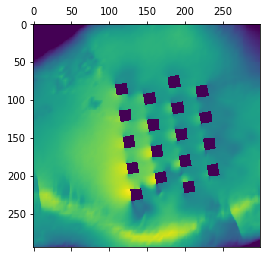

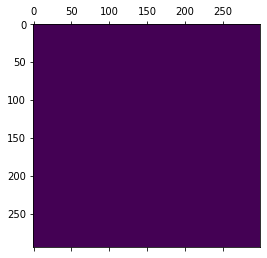

In [ ]:
test_set = timesteps[train_size:]

test_raw = train_set[100, 0]
test = torch.Tensor(test_raw.flatten()).detach()
shp = test_set[5, 0].shape

#compressed = autoencoder.get_compressed(test)
img = autoencoder(torch.Tensor(test).to(cuda))

img = img.detach().cpu()

# Plot
#plt.title("Original")
plt.matshow(test_raw)

#plt.title("Reconstructed")
plt.matshow(img.reshape(shp[0], shp[1]))

### Feature Extraction 1
Problemi PCA: come ritornare al frame ricostruito?